In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import squidpy as sq
import sccellfie
import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

### Read Preprocessed Annotated Data 

In [4]:
adata = sc.read(filename=parent_dir / 'data/h5ad/filtered_normalized_data.h5ad')
adata

AnnData object with n_obs × n_vars = 174747 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [5]:
adata.var_names = adata.var["gene"].astype(str)
adata.var_names_make_unique()

In [6]:
counts = adata.obs.groupby(["Subject_ID","Treatment_Status"]).size().unstack()
counts

Treatment_Status  Treated  Untreated
Subject_ID                          
78410A1                 0       1384
89397                4727          0
92604                8421          0
95278A2                 0        460
118223A                 0       7142
120136               6998          0
120139                  0       7498
120140                  0       1606
120149               2501          0
120153               3060          0
120161               4029         16
468115              38940          0
1180097B                0       1808
1182412B              540          0
1182623B                0      10568
1192325B                0      13261
1204245B                0       1762
1207356B                0       4183
1209622B                0      21794
1216278B                0      31138
1228762B                0       2894
1258057B                0         17

In [31]:
patient_id = '1216278B' # 468115: treated or 1216278B: untreated

adata_one_patient = adata[adata.obs['Subject_ID'] == patient_id]
adata_one_patient

View of AnnData object with n_obs × n_vars = 31138 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

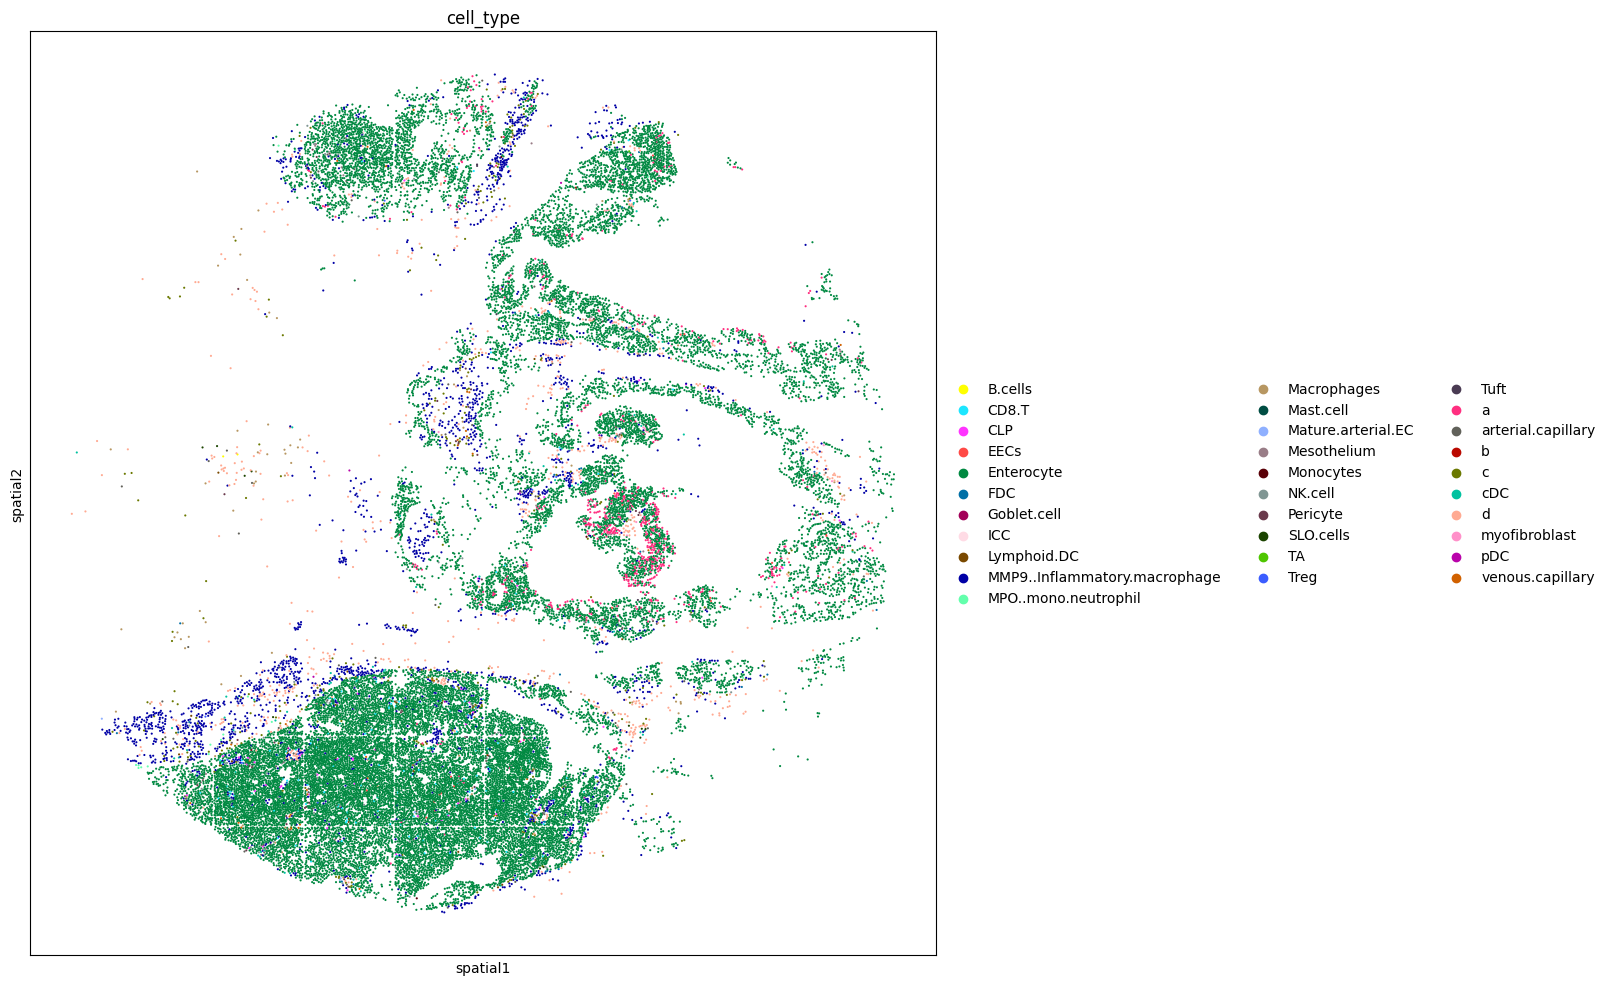

In [32]:
plt.rcParams["figure.figsize"] = (12, 12)
sc.pl.spatial(
    adata_one_patient,
    img_key=None,
    color="cell_type",
    spot_size=100,
    alpha_img=0.0,
)

### Compute Fluxomic (reaction/metabolic tasks) Data from Spatial Transcriptomic Data using scCellFie

In [33]:
results = sccellfie.run_sccellfie_pipeline(adata_one_patient,
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='nCount_Nanostring',
                                           process_by_group=False,
                                           groupby=None, # 'Treatment_Status' or None
                                           neighbors_key='neighbors',
                                           n_neighbors=10,
                                           batch_key='sample',
                                           threshold_key='sccellfie_threshold',
                                           smooth_cells=True,
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=True,
                                           save_folder=None, # 'result or None',
                                           save_filename=None, # 'sccellfie_results or None'
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (31138, 26)
Number of GPRs: 81
Shape of tasks by genes: (107, 26)
Shape of reactions by genes: (81, 26)
Shape of tasks by reactions: (107, 81)

---- scCellFie Step: Smoothing gene expression ----

---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----

---- scCellFie Step: Computing metabolic task activity ----
Removed 7 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Cell - Cell Communication Results for one patient

In [34]:
patient_adata = results["adata"]

In [35]:
tasks = patient_adata.metabolic_tasks.var_names
print("Number of metabolic tasks:", len(tasks))

Number of metabolic tasks: 100


### Select tasks based on the effect of Colorectal Cancer (CRC)

In [36]:
# filename: Task-Info.csv or Task_Info_with_CRC_binary.csv
task_info_df = pd.read_csv(base_dir / 'Task_Info_with_CRC_binary.csv')
crc_important_task = task_info_df[task_info_df['Upregulated_in_CRC'] == 1].reset_index(drop=True)
crc_important_task

Task  \
0   ATP generation from glucose (hypoxic condition...   
1                                   Alanine synthesis   
2                              Arachidonate synthesis   
3                                  Arginine synthesis   
4                                Asparagine synthesis   
5                                 Aspartate synthesis   
6                                  Ceramide synthesis   
7        Deoxyadenosine triphosphate synthesis (dATP)   
8         Deoxycytidine triphosphate synthesis (dCTP)   
9        Deoxyguanosine triphosphate synthesis (dGTP)   
10       Deoxythymidine triphosphate synthesis (dTTP)   
11                      Glucose to lactate conversion   
12                              Glutamine degradation   
13              Glutaminolysis (glutamine to lactate)   
14             Guanosine triphosphate synthesis (GTP)   
15                Hydroxymethylglutaryl-CoA synthesis   
16              Inosine monophosphate synthesis (IMP)   
17                                Palmitate synthesis   
18                     Phosphatidyl-choline synthesis   
19                Phosphatidyl-ethanolamine synthesis   
20                                  Proline synthesis   
21                   Recognition of misfolded protein   
22     Retro-translocation & substrate ubiquitination   
23                                 Serine degradation   
24                                   Serine synthesis   
25              Sialylation (addition of sialic acid)   
26                            Sphingomyelin synthesis   
27          Synthesis of L-kynurenine from tryptophan   
28  Synthesis of galactosyl glucosyl ceramide (lin...   
29                      Synthesis of glucocerebroside   
30                Synthesis of kynate from tryptophan   
31                           Synthesis of malonyl-coa   
32                         Synthesis of palmitoyl-CoA   
33                    Synthesis of ribose-5-phosphate   
34         Synthesis of thromboxane from arachidonate   
35                             Tryptophan degradation   
36               Uridine triphosphate synthesis (UTP)   
37                                  Vesicle secretion   

                      System                          Subsystem  \
0          ENERGY METABOLISM                     ATP GENERATION   
1     AMINO ACIDS METABOLISM                 ALANINE METABOLISM   
2          LIPIDS METABOLISM              FATTY ACID METABOLISM   
3     AMINO ACIDS METABOLISM                ARGININE METABOLISM   
4     AMINO ACIDS METABOLISM              ASPARAGINE METABOLISM   
5     AMINO ACIDS METABOLISM               ASPARTATE METABOLISM   
6          LIPIDS METABOLISM            SPHINGOLIPID METABOLISM   
7      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
8      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
9      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
10     NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
11  CARBOHYDRATES METABOLISM                PYRUVATE METABOLISM   
12    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
13    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
14     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
15         LIPIDS METABOLISM             CHOLESTEROL METABOLISM   
16     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
17         LIPIDS METABOLISM              FATTY ACID METABOLISM   
18         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
19         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
20    AMINO ACIDS METABOLISM                 PROLINE METABOLISM   
21              Proteostasis                               ERAD   
22              Proteostasis                               ERAD   
23    AMINO ACIDS METABOLISM                  SERINE METABOLISM   
24    AMINO ACIDS METABOLISM                  SERINE METABOLISM   
25   Processing in the Golgi        N-glycan processing (Golgi)   
26         LIPID

In [37]:
patient_task_df = pd.DataFrame(tasks.tolist(),columns=["Task"])
patient_task_info = pd.merge(patient_task_df, crc_important_task, left_on="Task", right_on="Task", how="left")
patient_task_info.dropna(inplace=True)
patient_task_info.reset_index(inplace=True, drop=True)
patient_task_info

Task  \
0   ATP generation from glucose (hypoxic condition...   
1                                   Alanine synthesis   
2                              Arachidonate synthesis   
3                                  Arginine synthesis   
4                                Asparagine synthesis   
5                                 Aspartate synthesis   
6                                  Ceramide synthesis   
7        Deoxyadenosine triphosphate synthesis (dATP)   
8         Deoxycytidine triphosphate synthesis (dCTP)   
9        Deoxyguanosine triphosphate synthesis (dGTP)   
10       Deoxythymidine triphosphate synthesis (dTTP)   
11                      Glucose to lactate conversion   
12                              Glutamine degradation   
13              Glutaminolysis (glutamine to lactate)   
14             Guanosine triphosphate synthesis (GTP)   
15                Hydroxymethylglutaryl-CoA synthesis   
16              Inosine monophosphate synthesis (IMP)   
17                                Palmitate synthesis   
18                     Phosphatidyl-choline synthesis   
19                Phosphatidyl-ethanolamine synthesis   
20                                  Proline synthesis   
21              Sialylation (addition of sialic acid)   
22                            Sphingomyelin synthesis   
23          Synthesis of L-kynurenine from tryptophan   
24  Synthesis of galactosyl glucosyl ceramide (lin...   
25                      Synthesis of glucocerebroside   
26                Synthesis of kynate from tryptophan   
27                           Synthesis of malonyl-coa   
28                         Synthesis of palmitoyl-CoA   
29                    Synthesis of ribose-5-phosphate   
30         Synthesis of thromboxane from arachidonate   
31                             Tryptophan degradation   
32               Uridine triphosphate synthesis (UTP)   
33                                  Vesicle secretion   

                      System                          Subsystem  \
0          ENERGY METABOLISM                     ATP GENERATION   
1     AMINO ACIDS METABOLISM                 ALANINE METABOLISM   
2          LIPIDS METABOLISM              FATTY ACID METABOLISM   
3     AMINO ACIDS METABOLISM                ARGININE METABOLISM   
4     AMINO ACIDS METABOLISM              ASPARAGINE METABOLISM   
5     AMINO ACIDS METABOLISM               ASPARTATE METABOLISM   
6          LIPIDS METABOLISM            SPHINGOLIPID METABOLISM   
7      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
8      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
9      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
10     NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
11  CARBOHYDRATES METABOLISM                PYRUVATE METABOLISM   
12    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
13    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
14     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
15         LIPIDS METABOLISM             CHOLESTEROL METABOLISM   
16     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
17         LIPIDS METABOLISM              FATTY ACID METABOLISM   
18         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
19         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
20    AMINO ACIDS METABOLISM                 PROLINE METABOLISM   
21   Processing in the Golgi        N-glycan processing (Golgi)   
22         LIPIDS METABOLISM            SPHINGOLIPID METABOLISM   
23    AMINO ACIDS METABOLISM              TRYPTOPHAN METABOLISM   
24         LIPIDS METABOLISM             GANGLIOSIDE METABOLISM   
25         LIPIDS METABOLISM             GANGLIOSIDE METABOLISM   
26    AMINO ACIDS METABOLISM              TRYPTOPHAN METABOLISM   
27         LIPIDS METABOLISM              FATTY ACID METABOLISM   
28         LIPIDS METABOLISM              FATTY ACID METABOLISM   
29  CARBOHYDRATES METABOLISM          PENTO

## Metabolic Task Analysis

### Correlation analysis (Spearman)

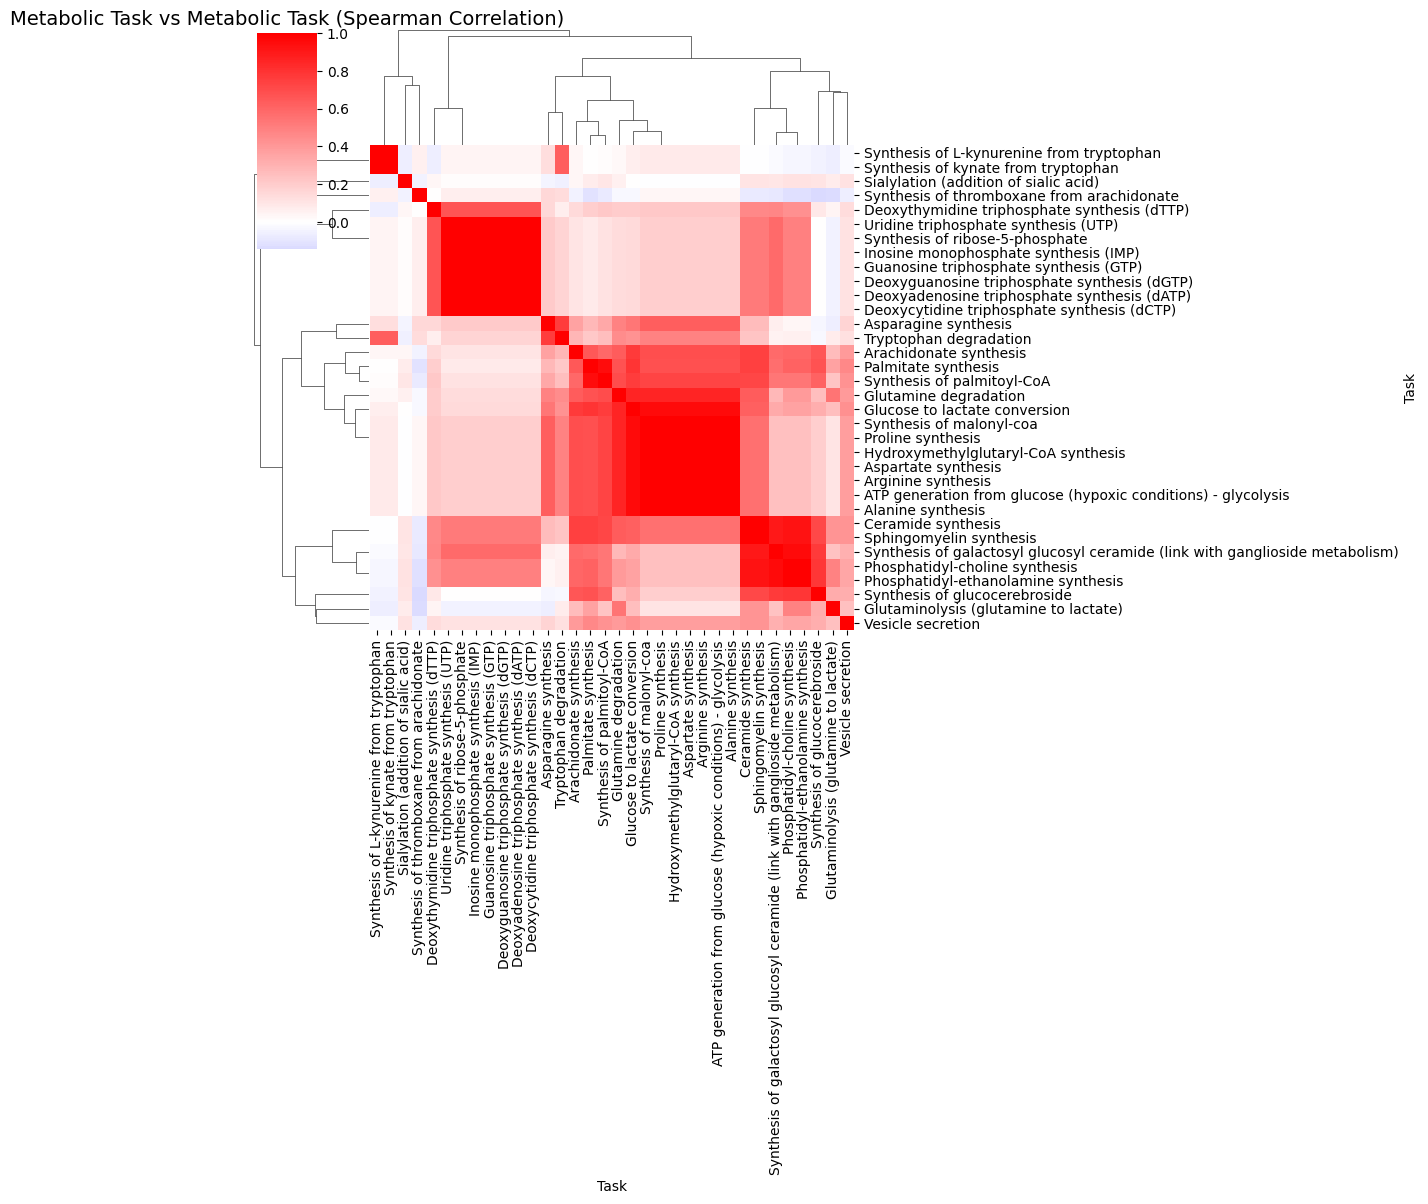

In [38]:
mt_df = patient_adata.metabolic_tasks.to_df()

corr_matrix = mt_df.corr(method='spearman')

corr_matrix_filtered = corr_matrix.loc[patient_task_info.Task.tolist(), patient_task_info.Task.tolist()]

pivot = corr_matrix_filtered.replace([np.inf, -np.inf], np.nan).fillna(0)

sns.clustermap(
    pivot,
    cmap='bwr',
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Metabolic Task vs Metabolic Task (Spearman Correlation)", fontsize=14)
plt.show()


### Finding low, moderate, and high correlation pairs

In [39]:
# Set self-correlations (diagonal) to NaN so they are ignored
np.fill_diagonal(corr_matrix_filtered.values, np.nan)

# Convert correlation matrix to long format
corr_matrix_filtered.index.name = 'task_1'
corr_matrix_filtered.columns.name = 'task_2'
corr_long = corr_matrix_filtered.stack().reset_index(name='correlation')

# Remove duplicates (A–B same as B–A)
corr_long['pair'] = corr_long.apply(lambda x: tuple(sorted([x['task_1'], x['task_2']])), axis=1)
corr_long = corr_long.drop_duplicates(subset='pair').drop(columns='pair')

# Sort by correlation value
corr_sorted = corr_long.sort_values(by='correlation', ascending=True).reset_index(drop=True)

# Get lowest, mid, and highest
lowest = corr_sorted.iloc[0]
mid = corr_sorted.iloc[len(corr_sorted)//2]
highest = corr_sorted.iloc[-1]

print("🔻 Lowest correlated pair:")
print(f"  {lowest.task_1}  ↔  {lowest.task_2}  |  correlation = {lowest.correlation:.3f}")

print("\n⚖️  Mid-level correlated pair:")
print(f"  {mid.task_1}  ↔  {mid.task_2}  |  correlation = {mid.correlation:.3f}")

print("\n🔺 Highest correlated pair:")
print(f"  {highest.task_1}  ↔  {highest.task_2}  |  correlation = {highest.correlation:.3f}")


🔻 Lowest correlated pair:
  Synthesis of glucocerebroside  ↔  Synthesis of thromboxane from arachidonate  |  correlation = -0.142

⚖️  Mid-level correlated pair:
  Deoxythymidine triphosphate synthesis (dTTP)  ↔  Hydroxymethylglutaryl-CoA synthesis  |  correlation = 0.214

🔺 Highest correlated pair:
  ATP generation from glucose (hypoxic conditions) - glycolysis  ↔  Alanine synthesis  |  correlation = 1.000


### Visaulization of metabolic task value on spatial data

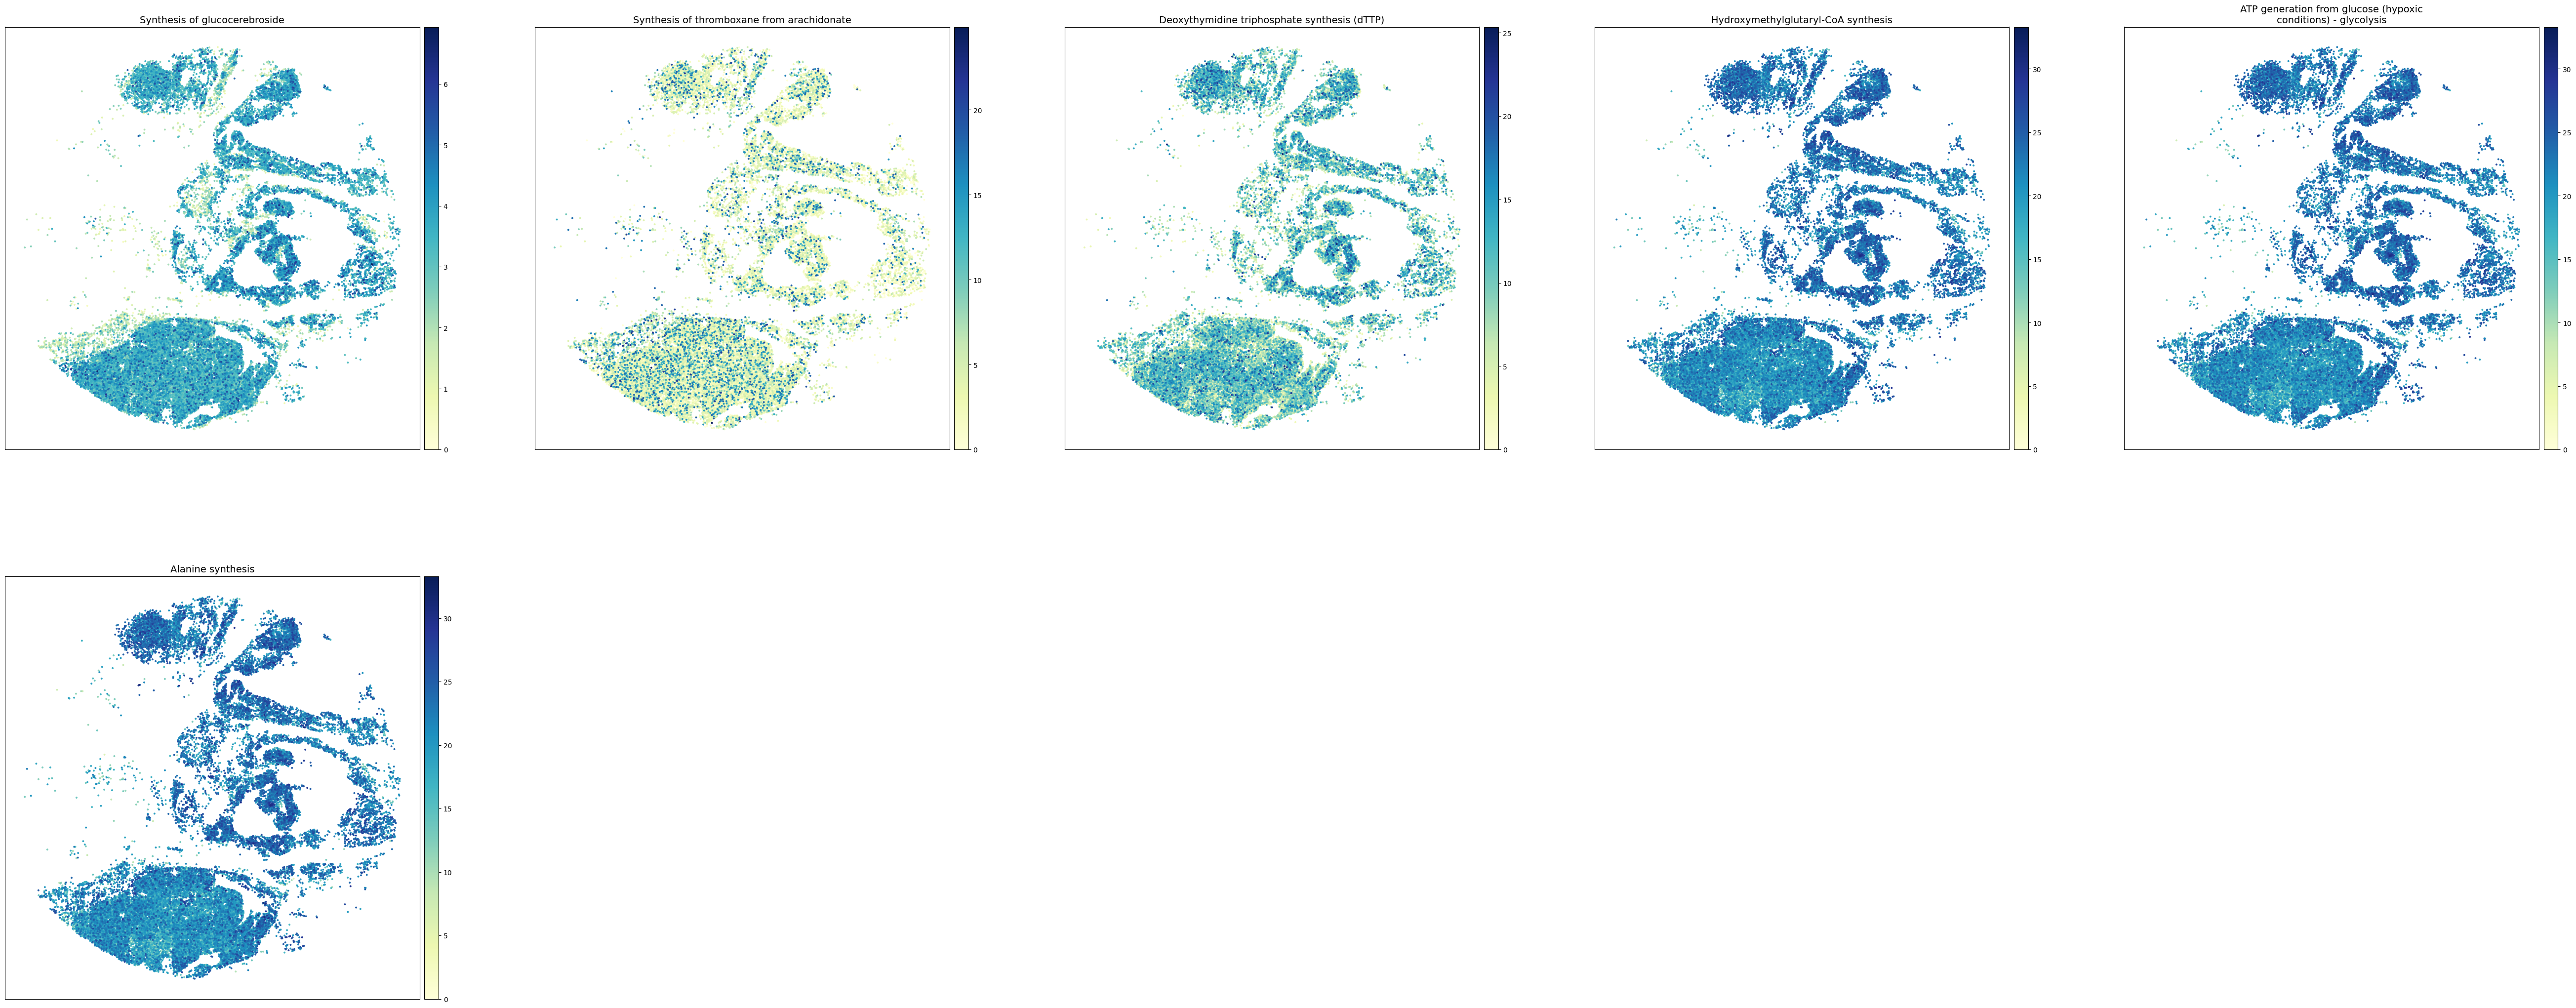

In [40]:
fig, axes = sccellfie.plotting.plot_spatial(patient_adata.metabolic_tasks,
                                            keys=[lowest.task_1, lowest.task_2, mid.task_1, mid.task_2,
                                                   highest.task_1, highest.task_2],
                                            spot_size=200, 
                                            cmap='YlGnBu',
                                            use_raw=False,
                                            ncols=5,
                                            hspace=0.3,
                                            vmin=0,
                                            save=patient_id
                                            )

### 🧠 Moran’s I — Spatial Autocorrelation Measure

---

#### 📘 Definition  
**Moran’s I** quantifies how similar the values of a variable are among neighboring spatial locations.  
It measures the degree of **spatial autocorrelation** — that is, whether similar values tend to occur close to each other in space.

---

#### 🔬 Purpose in Spatial Omics  
Helps identify whether **gene expression** or **metabolic task scores** form:  
- 🟢 **Spatial clusters** — similar values near each other (high positive correlation)  
- ⚪ **Random patterns** — no clear spatial structure (Moran’s I ≈ 0)  
- 🔴 **Alternating patterns** — neighboring cells with opposite values (negative correlation)

---

#### 🧮 Mathematical Formula

$$
I = \frac{N}{W} \cdot 
    \frac{\sum_i \sum_j w_{ij} (x_i - \bar{x})(x_j - \bar{x})}
         {\sum_i (x_i - \bar{x})^2}
$$

**where:**

- $N$: number of spatial units (cells or spots)  
- $x_i$: value at cell *i*  
- $w_{ij}$: spatial weight (1 if neighbors, 0 if not)  
- $W = \sum_i \sum_j w_{ij}$: sum of all weights

---

#### 📊 Interpretation

| Moran’s I value | Meaning | Spatial Pattern |
|-----------------|----------|-----------------|
| **≈ +1** | Strong positive autocorrelation | Clustered |
| **≈ 0** | No spatial structure | Random |
| **≈ −1** | Strong negative autocorrelation | Dispersed / Checkerboard |

---

#### 🧬 Example in Spatial Transcriptomics  
Tasks or genes with high **Moran’s I** show **spatial organization**,  
e.g. glycolysis active only in a tumor region → Moran’s I = +0.7. Genes with Moran’s I ≈ 0 show random expression across tissue.

In [41]:
sq.gr.spatial_neighbors(patient_adata.metabolic_tasks, coord_type="generic", n_neighs=6)
sq.gr.spatial_autocorr(patient_adata.metabolic_tasks, mode="moran", genes=tasks)

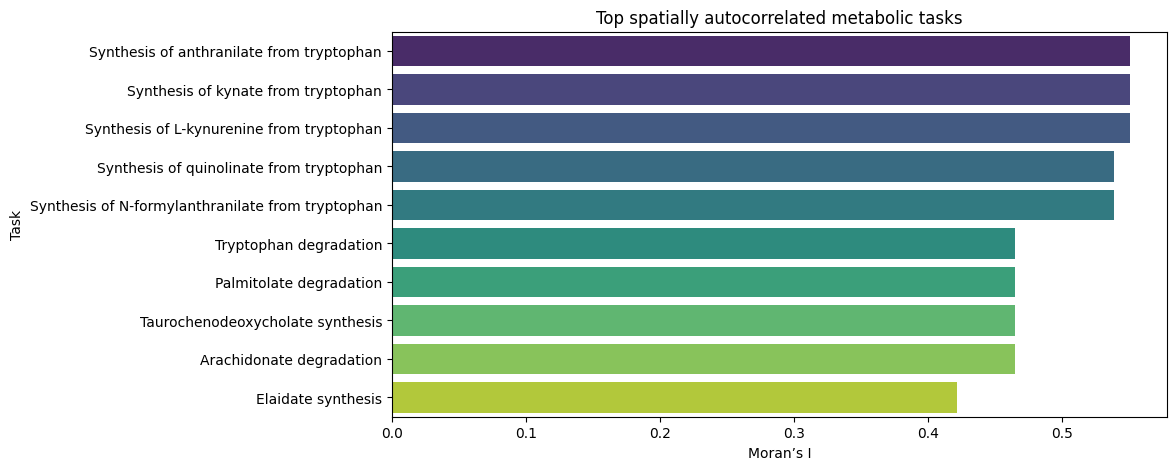

In [42]:
patient_moran = patient_adata.metabolic_tasks.uns["moranI"]
top_tasks = patient_moran.sort_values("I", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="I", y=top_tasks.index, data=top_tasks, palette="viridis")
plt.title("Top spatially autocorrelated metabolic tasks")
plt.xlabel("Moran’s I")
plt.ylabel("Task")
plt.show()

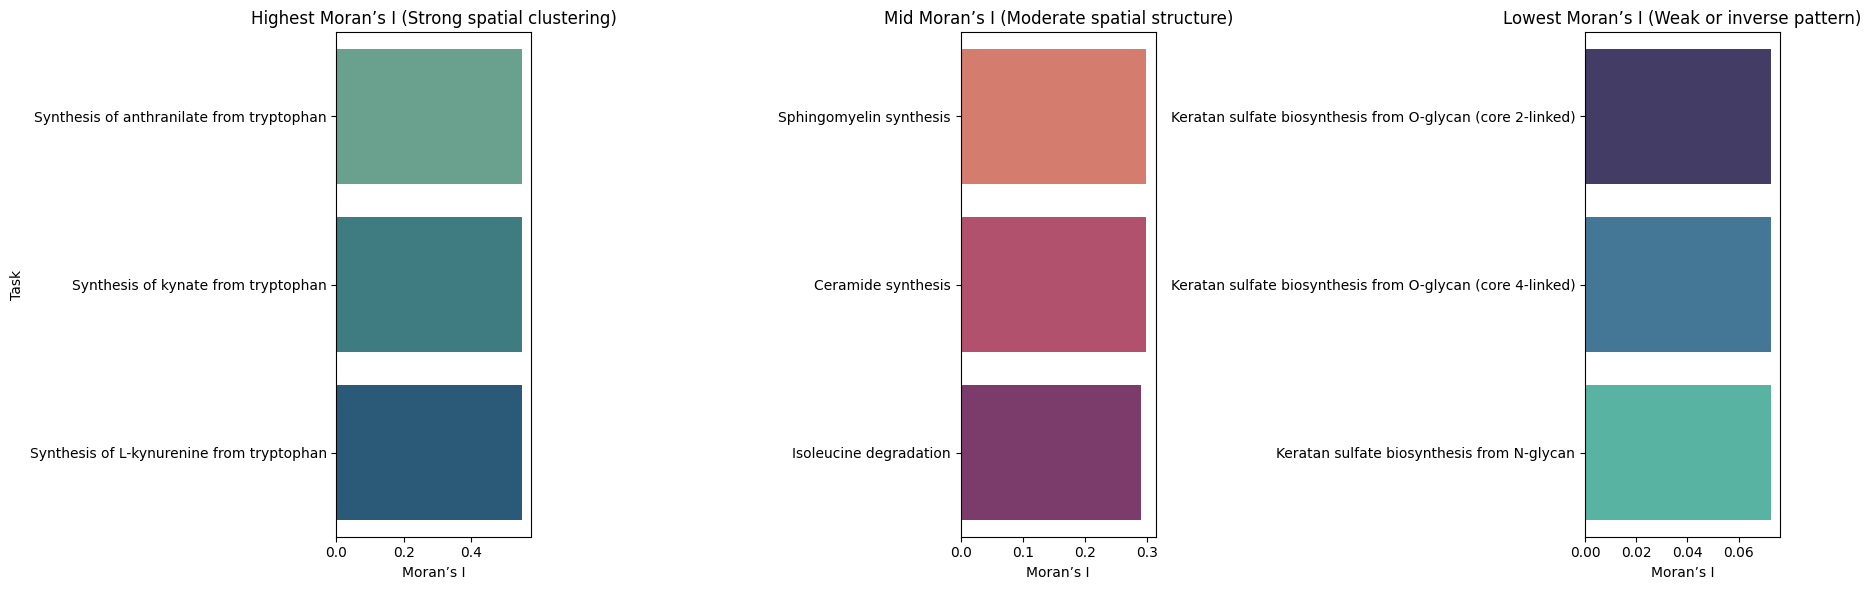

In [43]:
patient_moran = patient_adata.metabolic_tasks.uns["moranI"]

patient_moran_sorted = patient_moran.sort_values("I", ascending=False)

top_highest = patient_moran_sorted.head(3)
top_lowest = patient_moran_sorted.tail(3)
mid_start = len(patient_moran_sorted)//2 - 5
top_mid = patient_moran_sorted.iloc[mid_start:mid_start+3]

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=False)

sns.barplot(x="I", y=top_highest.index, data=top_highest, palette="crest", ax=axes[0])
axes[0].set_title("Highest Moran’s I (Strong spatial clustering)")
axes[0].set_xlabel("Moran’s I")
axes[0].set_ylabel("Task")

sns.barplot(x="I", y=top_mid.index, data=top_mid, palette="flare", ax=axes[1])
axes[1].set_title("Mid Moran’s I (Moderate spatial structure)")
axes[1].set_xlabel("Moran’s I")
axes[1].set_ylabel("")

sns.barplot(x="I", y=top_lowest.index, data=top_lowest, palette="mako", ax=axes[2])
axes[2].set_title("Lowest Moran’s I (Weak or inverse pattern)")
axes[2].set_xlabel("Moran’s I")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


In [44]:
# Get the min and max Moran's I values
max_task = patient_moran.loc[patient_moran['I'].idxmax()]
min_task = patient_moran.loc[patient_moran['I'].idxmin()]

print("🔺 Highest Moran’s I:")
print(f"  Task: {max_task.name}")
print(f"  I = {max_task['I']:.4f}")

print("\n🔻 Lowest Moran’s I:")
print(f"  Task: {min_task.name}")
print(f"  I = {min_task['I']:.4f}")

# Check if there are any negative values
neg_count = (patient_moran['I'] < 0).sum()
print(f"\n📉 Number of tasks with negative Moran’s I: {neg_count}")

if neg_count > 0:
    print("⚠️ Some tasks have negative Moran’s I → dispersed or alternating spatial patterns.")
else:
    print("✅ All Moran’s I values are positive → all tasks show clustered or random patterns.")


🔺 Highest Moran’s I:
  Task: Synthesis of anthranilate from tryptophan
  I = 0.5505

🔻 Lowest Moran’s I:
  Task: Keratan sulfate biosynthesis from N-glycan
  I = 0.0726

📉 Number of tasks with negative Moran’s I: 0
✅ All Moran’s I values are positive → all tasks show clustered or random patterns.


### Create KNN Neighbors graph

In [45]:
sccellfie.spatial.create_knn_network(patient_adata.metabolic_tasks, n_neighbors=10, spatial_key='spatial')

In [46]:
patient_adata_transfer = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=patient_adata,
    adata_source=patient_adata.metabolic_tasks,
    var_names=patient_adata.metabolic_tasks.var_names
)
patient_adata_transfer

AnnData object with n_obs × n_vars = 31138 × 126
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    uns: 'cell_type_colors', 'normalization', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'smoothed_X', 'gene_scores'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

### Finding best Radius for Colocalization

In [47]:
r = sccellfie.spatial.compute_neighbor_distribution(
    patient_adata_transfer,
    radius_range=(100, 1500),  
    n_points=200,
    spatial_key='spatial'
)

(<Figure size 1500x800 with 4 Axes>, GridSpec(2, 3))

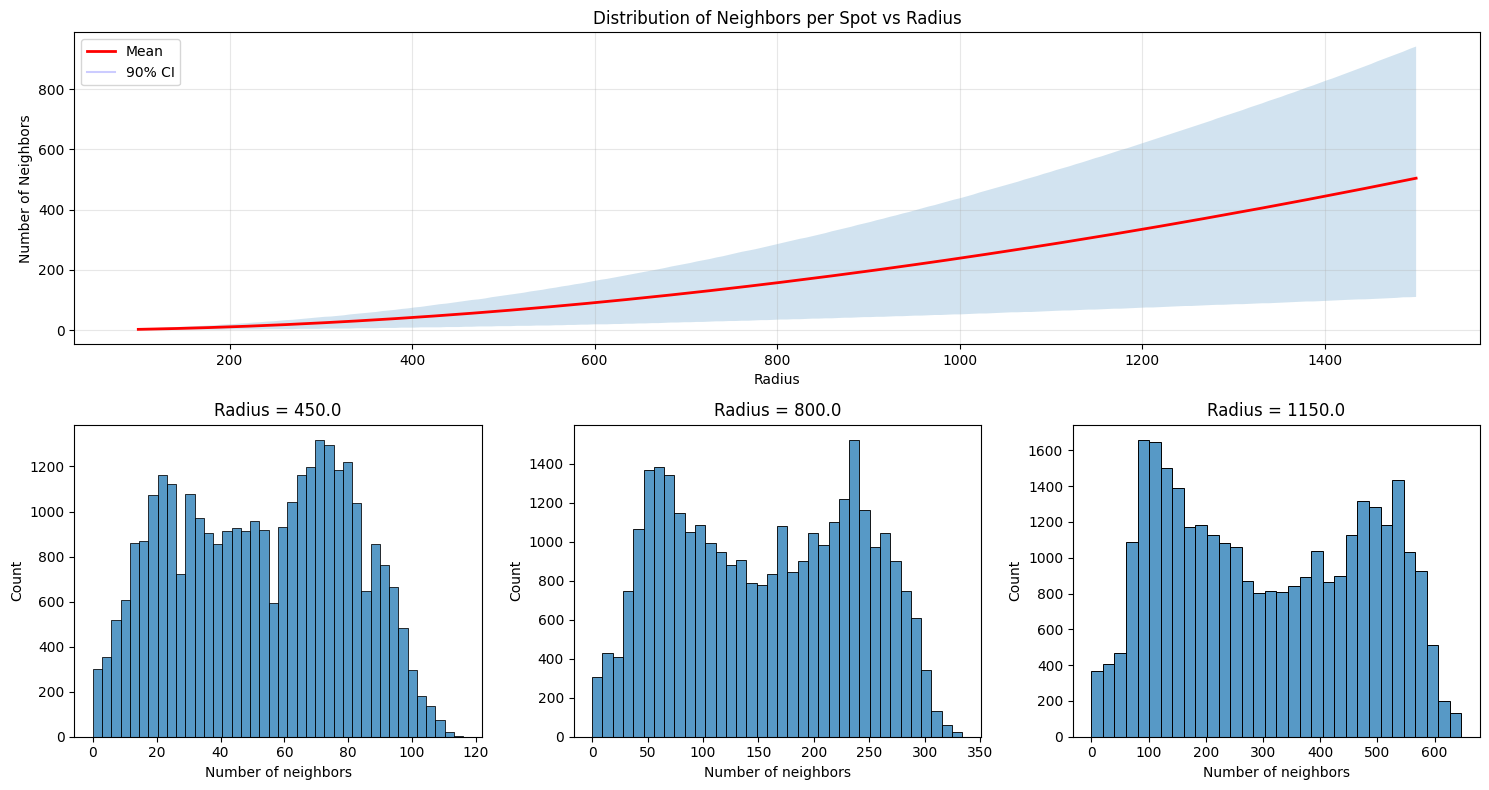

In [48]:
sccellfie.plotting.spatial.plot_neighbor_distribution(r)

## Colocalization analysis for selected pairs


🧬 Computing colocalization for Lowest: Synthesis of glucocerebroside - Synthesis of thromboxane from arachidonate ...
✅ Done computing colocalization for Lowest: Synthesis of glucocerebroside - Synthesis of thromboxane from arachidonate


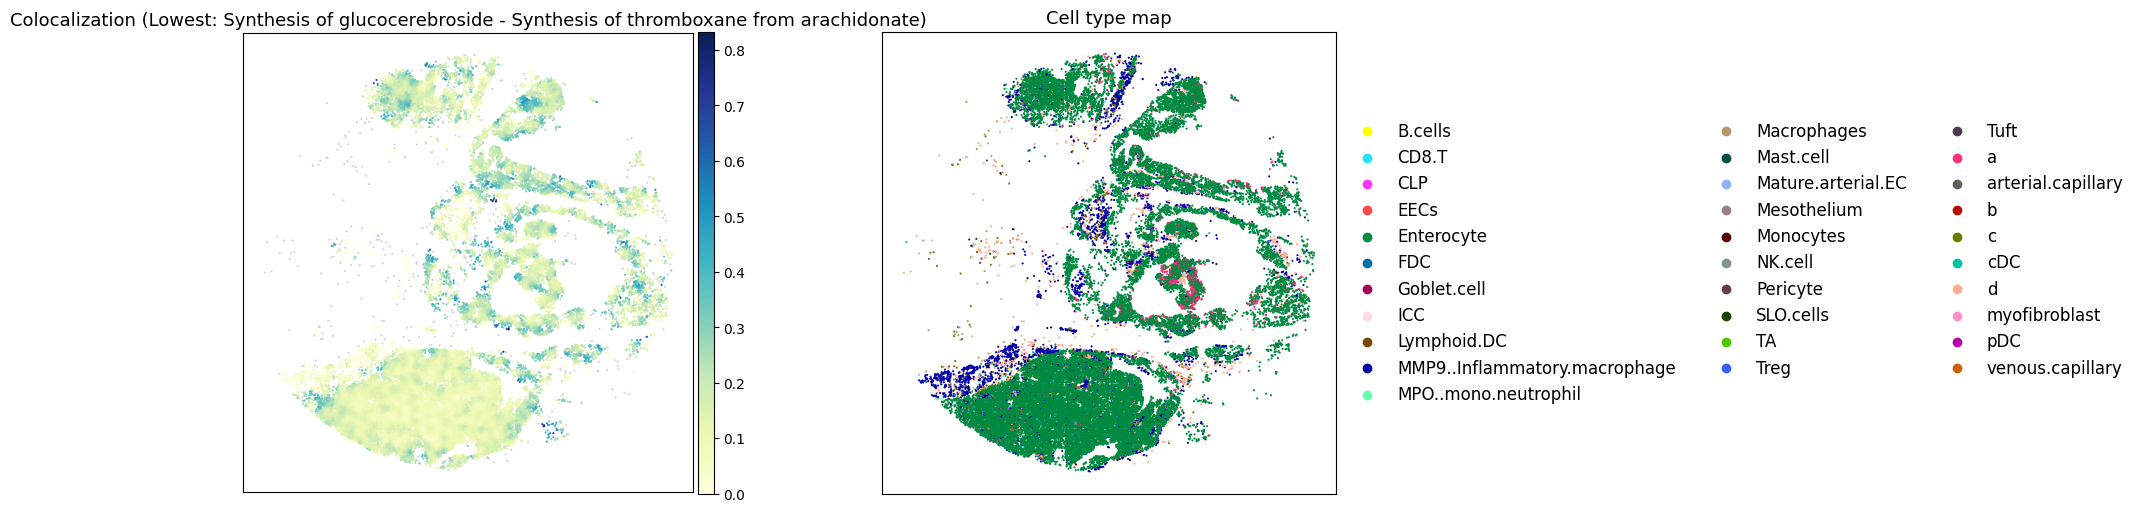

💾 Saved figure to: colocalization_pairs/Lowest_colocalization_Synthesis of glucocerebroside_vs_Synthesis of thromboxane from arachidonate.png

🧬 Computing colocalization for Mid: Deoxythymidine triphosphate synthesis (dTTP) - Hydroxymethylglutaryl-CoA synthesis ...
✅ Done computing colocalization for Mid: Deoxythymidine triphosphate synthesis (dTTP) - Hydroxymethylglutaryl-CoA synthesis


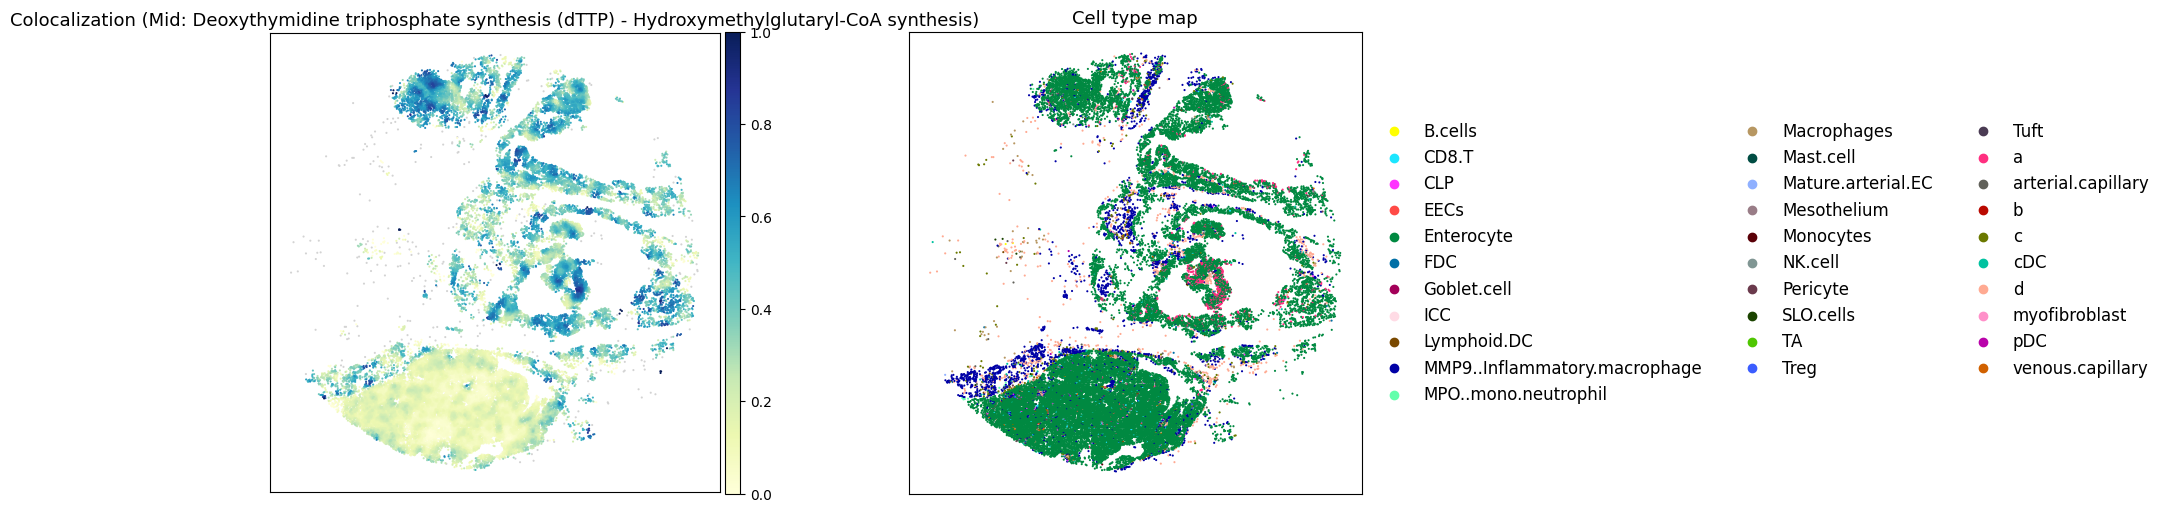

💾 Saved figure to: colocalization_pairs/Mid_colocalization_Deoxythymidine triphosphate synthesis (dTTP)_vs_Hydroxymethylglutaryl-CoA synthesis.png

🧬 Computing colocalization for Highest: ATP generation from glucose (hypoxic conditions) - glycolysis - Alanine synthesis ...
✅ Done computing colocalization for Highest: ATP generation from glucose (hypoxic conditions) - glycolysis - Alanine synthesis


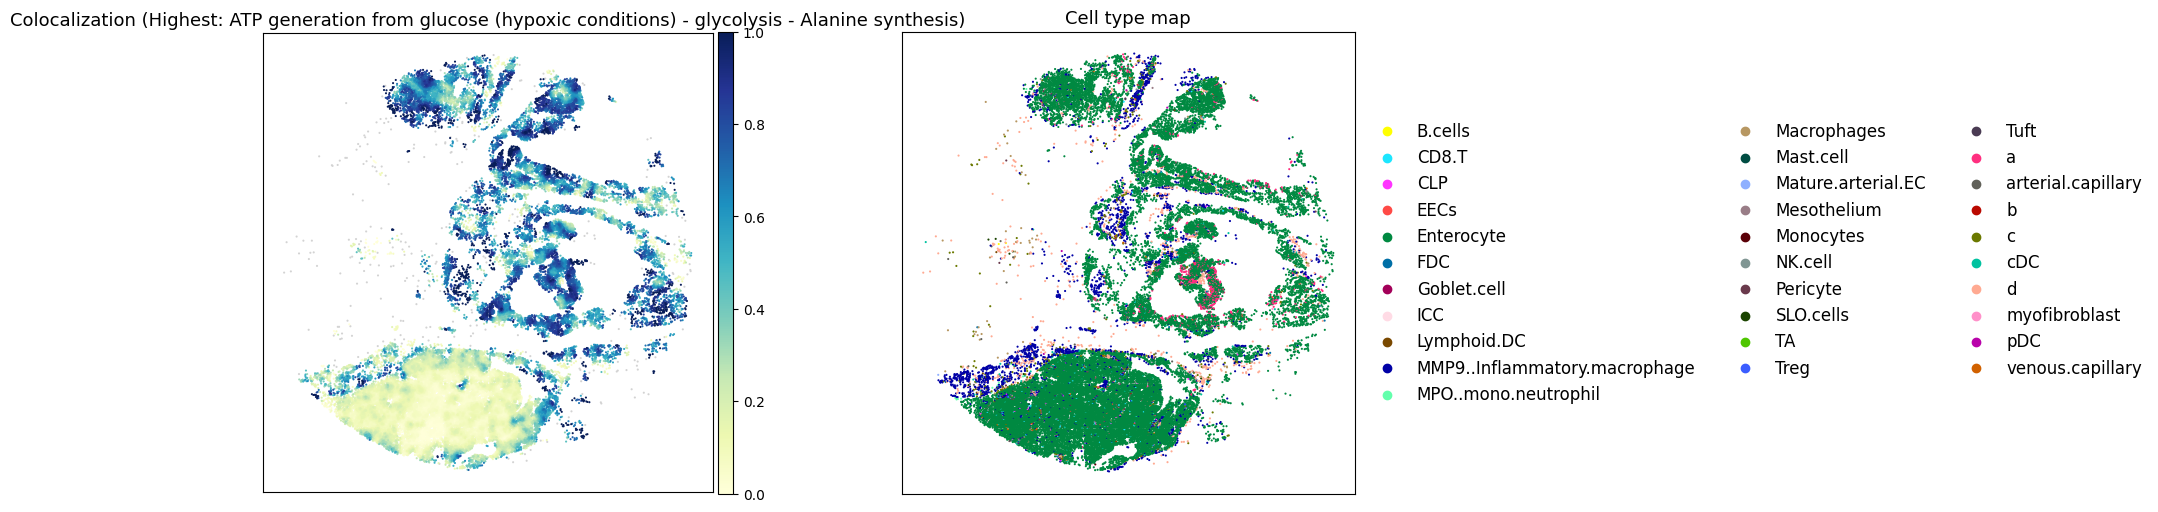

💾 Saved figure to: colocalization_pairs/Highest_colocalization_ATP generation from glucose (hypoxic conditions) - glycolysis_vs_Alanine synthesis.png

✅ All three colocalization maps generated and saved successfully.


In [49]:
# Folder to save results
os.makedirs("colocalization_pairs", exist_ok=True)

# Prepare the task pairs list
task_pairs = [
    ("Lowest", lowest.task_1, lowest.task_2),
    ("Mid", mid.task_1, mid.task_2),
    ("Highest", highest.task_1, highest.task_2)
]

# Loop over each pair
for level, task1, task2 in task_pairs:
    title = f"{level}: {task1} - {task2}"
    print(f"\n🧬 Computing colocalization for {title} ...")

    # Compute local colocalization score
    patient_adata_transfer.obs[title] = sccellfie.communication.compute_local_colocalization_scores(
        patient_adata_transfer,
        var1=task1,
        var2=task2,
        neighbors_radius=400,
        method='pairwise_concordance',
        min_neighbors=3,
        spatial_key='spatial',
        inplace=False
    )

    print(f"✅ Done computing colocalization for {title}")

    # ---- Plot colocalization (left) + cell type (right) ----
    keys = [title, 'cell_type']

    fig, axes = sccellfie.plotting.plot_spatial(
        patient_adata_transfer,
        keys=keys,
        cmap='YlGnBu',
        spot_size=200,
        use_raw=False,
        ncols=2,
        vmin=0,
        wspace=0.25,
        hspace=0.3
    )

    # Custom titles (above plots)
    axes[0].set_title(f"Colocalization ({title})", fontsize=13)
    axes[1].set_title("Cell type map", fontsize=13)

    # Layout adjustments
    fig.set_size_inches(14, 6)
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.25)

    # Show plot
    plt.show()

    # Save figure
    save_path = f"colocalization_pairs/{level}_colocalization_{task1}_vs_{task2}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved figure to: {save_path}")

print("\n✅ All three colocalization maps generated and saved successfully.")


In [50]:
# Select the target columns
cols_of_interest = [f"{level}: {task1} - {task2}" for level, task1, task2 in task_pairs]


# Create a DataFrame combining obs (cell metadata) and selected task columns
df = patient_adata_transfer.obs[["cell_type"] + cols_of_interest].copy()

# Group by cell type and calculate mean and standard deviation
grouped_mean = df.groupby("cell_type")[cols_of_interest].mean()
grouped_std = df.groupby("cell_type")[cols_of_interest].std()

# Combine results for clear display
summary = grouped_mean.round(3)
summary_std = grouped_std.round(3)

print("Mean activity per cell type:")
display(summary)

print("\nStandard deviation per cell type:")
display(summary_std)

Mean activity per cell type:


Lowest: Synthesis of glucocerebroside - Synthesis of thromboxane from arachidonate  \
cell_type                                                                                                           
B.cells                                                                    0.000                                    
CD8.T                                                                      0.117                                    
CLP                                                                        0.136                                    
EECs                                                                       0.131                                    
Enterocyte                                                                 0.148                                    
FDC                                                                        0.159                                    
Goblet.cell                                                                0.109                                    
ICC                                                                        0.148                                    
Lymphoid.DC                                                                0.126                                    
MMP9..Inflammatory.macrophage                                              0.114                                    
MPO..mono.neutrophil                                                       0.164                                    
Macrophages                                                                0.116                                    
Mast.cell                                                                  0.145                                    
Mature.arterial.EC                                                         0.112                                    
Mesothelium                                                                0.201                                    
Monocytes                                                                  0.131                                    
NK.cell                                                                    0.143                                    
Pericyte                                                                   0.135                                    
SLO.cells                                                                  0.134                                    
TA                                                                         0.201                                    
Treg                                                                       0.128                                    
Tuft                                                                       0.153                                    
a                                                                          0.175                                    
arterial.capillary                                                         0.157                                    
b                                                                          0.203                                    
c                                                                          0.134                                    
cDC                                                                        0.174                                    
d                                                                          0.130                                    
myofibroblast                                                              0.210                                    
pDC                                                                        0.120                                    
venous.capillary                                                           0.145                                    

                               Mid: Deoxythymidine triphosphate synthesis (dTTP) - Hydroxymethylglutaryl-CoA synthesis  \
cell_type                                      


Standard deviation per cell type:


Lowest: Synthesis of glucocerebroside - Synthesis of thromboxane from arachidonate  \
cell_type                                                                                                           
B.cells                                                                      NaN                                    
CD8.T                                                                      0.045                                    
CLP                                                                        0.074                                    
EECs                                                                       0.081                                    
Enterocyte                                                                 0.080                                    
FDC                                                                        0.102                                    
Goblet.cell                                                                  NaN                                    
ICC                                                                        0.054                                    
Lymphoid.DC                                                                0.077                                    
MMP9..Inflammatory.macrophage                                              0.092                                    
MPO..mono.neutrophil                                                       0.076                                    
Macrophages                                                                0.104                                    
Mast.cell                                                                  0.058                                    
Mature.arterial.EC                                                         0.050                                    
Mesothelium                                                                0.071                                    
Monocytes                                                                  0.063                                    
NK.cell                                                                    0.067                                    
Pericyte                                                                   0.067                                    
SLO.cells                                                                  0.116                                    
TA                                                                           NaN                                    
Treg                                                                       0.055                                    
Tuft                                                                       0.095                                    
a                                                                          0.073                                    
arterial.capillary                                                         0.082                                    
b                                                                            NaN                                    
c                                                                          0.088                                    
cDC                                                                        0.086                                    
d                                                                          0.106                                    
myofibroblast                                                              0.061                                    
pDC                                                                        0.056                                    
venous.capillary                                                           0.083                                    

                               Mid: Deoxythymidine triphosphate synthesis (dTTP) - Hydroxymethylglutaryl-CoA synthesis  \
cell_type                                      

<Figure size 1400x600 with 0 Axes>

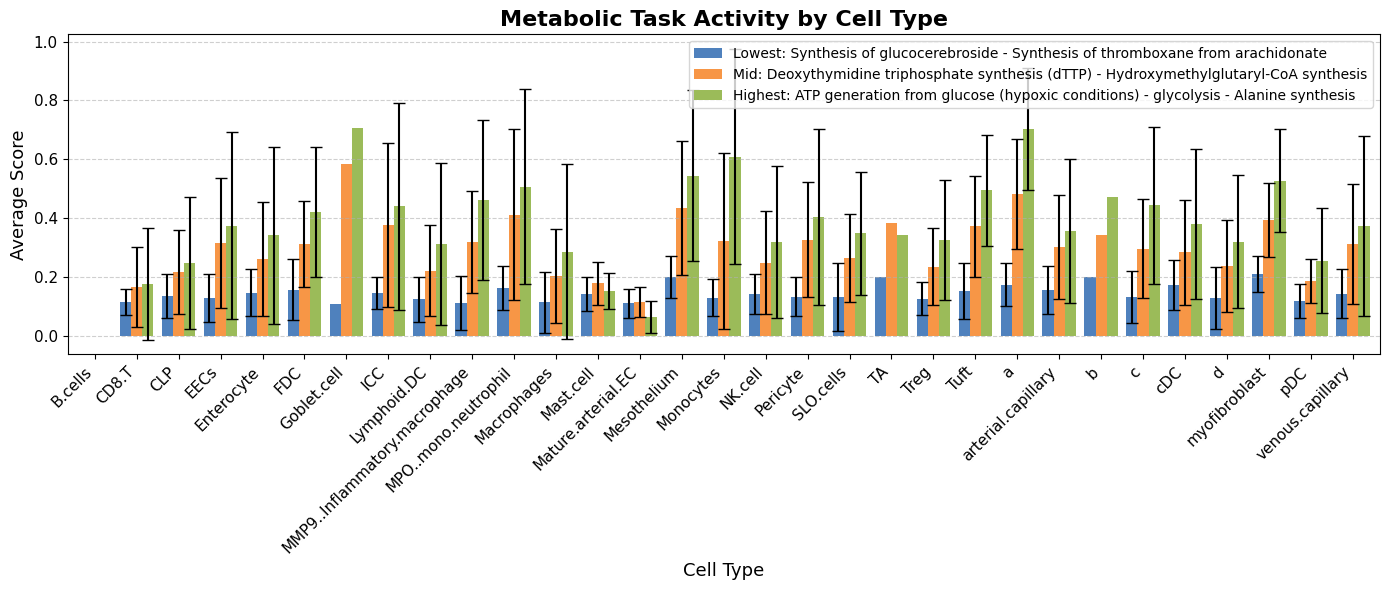

In [51]:
plt.figure(figsize=(14,6))  
summary.plot(
    kind='bar', 
    yerr=summary_std, 
    capsize=4, 
    figsize=(14,6),
    width=0.8,
    color=['#4F81BD', '#F79646', '#9BBB59']  
)

plt.title('Metabolic Task Activity by Cell Type', fontsize=16, fontweight='bold')
plt.ylabel('Average Score', fontsize=13)
plt.xlabel('Cell Type', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
